# TODOs
- [X] Metadaten.json zu Python Variablen, in Python Dictionary einspeisen und auslesen (Parkplätze, WiFi) -> Frank
- [X] Map (Slider, Heat Map, Animationen) Visualisierungen -> Frank
- [X] virtual env vorbereiten -> Rich
- [X] projektserver? -> Rich
- [X] Erste Statistiken (Bar Charts, Graphs usw.) Visualisierungen -> Rich
- [ ] Chart Ideen -> Anja
- [ ] Unsere Daten in PowerBI einspeisen, (welche Daten bräuchten wir z.B. für Graph Bubble oder allgemeine Sachen) oder was kostenloses (z.B. CliqSense) -> Anja

# Unsere Quellen zum Visualisierungserfolg:
### Wie Wähle ich die richtige Visualisierung?

https://eazybi.com/blog/data_visualization_and_chart_types/

### Wo finde ich sie in Python?

https://python-graph-gallery.com

# Domänenwissen

* Öffnungszeiten (Theater, Uni)
* Peak Times, Tag
* Ferienzeiten
* Special Events (Demos, Strassensperren)
* Parkplätze kostenlos/bezahlt?
* Sonntag Flohmarkt

# Ideen
* Vergleich mit Wetterdaten
* Verlgeich mit Öffis -> Empfehlungen aussprechen -> z.B. mehr Busse sollen fahren, aber eine U-Bahn kann ausfallen
* Anhand von hauptsächlich Fußgänger könnte man behaupten, wann Vorlesungen auf der TU sind

# Korrelation
* Wie viele fahren rein um bestimmte Uhrzeit rein -> Belegung Parkplätze
* WiFi Nutzung in Zusammenhang mit parkenden Autos?

# Prädiktionen (ML)
* Traffic-/Personenaufkommen zu bestimmten Tageszeiten

# Distribution
* Normalverteilung

# Intervall
* Tageszeiten
* Wochen

# Fragen flow.lab
* Wie wurden Pedestrian Daten aufgenommen?
* Was sind die Daten bei WiFi?
* Gibt es schon Ergebnisse aus Wettbewerb?
* Gibt es neue Daten?
* Erklärung zu Datenset?

## Data für PowerBI

1. Parking:
i. menschlich lesbaren namen geben
ii. TIme in excel format speichern 
    a. wochen (später statistik woche zu woche)
    b. wochentage ( stat wochentag zu denselben ander woche)
    c. tageszeit ( stat pro tag)
    d. Alle Stat über ganze periode, woche, tag
    e. Balkendia mit max-belegung durch tag, woche, ganze periode
    f. haufigkeit der belegung

2. Trafic:
i. Time in excel format speichern
ii. klären was ist overall

3. wifi:
i. no legend - no ststistics

4. pedestrian:
i. Time!
ii. wir können allgemein menschenZahl in bezug zu Zeit analysieren. 
Bsp. 12:00 = 234 am Platz

zu alle : 1 Korellation mit Zeit prüfen
          2 alle Intervalle auf einander legen  - Min Max Median Mittelwert
	  3 Hypotesen: 
		Studis parken
		Flohmarkt parkt
		Stosszeiten ermitteln und gegenbeispiel untersuchen. siehe 2
		Normalverteilt? siehe 2

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import folium.plugins as plugins
from IPython.display import HTML
import sklearn as sk
import numpy as np
import json

In [5]:
# Hide Code Function

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Erklärungen/Links zu wichtigen Libraries
- Markdown schreiben hier in Jupyter: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet
- folium für map Visualisierungen: https://github.com/python-visualization/folium

### Daten einlesen
> Erns-Reuter-Platz Datensatz aus http://flow.dai-labor.de

In [6]:
wifi = pd.read_csv('data/wifi.csv')
parking = pd.read_csv('data/parking.csv', delimiter=' ')
# TODO: hier restlichen Datensätze einlesen

### Sinn aus den Daten machen 

In [7]:
# TODO: alle Typen aus der metadata.json in Python Variablen, z.B.:
campus_eb = [52.512388, 13.32360925]
campus_tel = [52.51298775, 13.32029525]
ernst_reuter_platz_center = [52.512611, 13.321856]

# TODO: json daten auslesen
metadata = json.loads(open('data/metadata.json').read())

wifi_latlon = metadata['wifi']['latlon']
pedestrian_latlon = metadata['pedestrian']['latlon']
traffic_latlon = metadata['traffic']['latlon']
parking_latlon = metadata['parking']['latlon']

### Wichtige Libraries
- folium für map Visualisierungen: https://github.com/python-visualization/folium

### Alle WiFi Standorte auf Karte visualisieren

In [8]:
## TODO: take center of ernst-reuter platz as location=POINT
map = folium.Map(location=ernst_reuter_platz_center, zoom_start=17)


for key in wifi_latlon:
    folium.Circle(
        radius=50,
        location=wifi_latlon[key],
        popup=key,
        color='#3186cc',
        fill=True
    ).add_to(map)
    
for key in pedestrian_latlon:
    folium.Marker(
        location=pedestrian_latlon[key],
        popup=key,
        icon=folium.Icon(icon='info-sign')
    ).add_to(map)
    
for key in traffic_latlon:
    folium.Marker(
        location=traffic_latlon[key],
        popup=key,
        icon=folium.Icon(color='red',icon='info-sign')
    ).add_to(map)

for key in parking_latlon:
    folium.Circle(
        radius=2,
        location=parking_latlon[key],
        popup=key,
        color='red',
        fill=True
    ).add_to(map)

map

### Zum Vergleich Originalstandorte:
(TODO: Karte rotieren?)

![Sensor_Locations](images/Sensor_Locations.jpg)

### Parking Data

In [9]:
mean_parking = {}

startTime = float(parking[['Timestamp']].iloc[0])
endTime = float(parking[['Timestamp']].iloc[-1])
timeSpan = endTime - startTime

for key in parking_latlon:
    temp = parking[parking['ParkingSpotID'] == key][['Timestamp','Occupied']]
    occupied = temp.iloc[0]['Occupied'] == 1
    lastTime = startTime
    mean_parking[key] = 0
    for index, row in temp.iterrows():
        if occupied != (row['Occupied'] == 1):
            if occupied:
                mean_parking[key] += row['Timestamp'] - lastTime
            else:
                lastTime = row['Timestamp']
            occupied = row['Occupied'] == 1
    if occupied:
                mean_parking[key] += endTime - lastTime
    mean_parking[key] /= timeSpan
    print(key, ":", mean_parking[key])
            
##for key in parking_latlon:  
##    mean_parking[key] = parking[parking['ParkingSpotID'] == key][['Occupied']].mean()    
## This is the wrong aproach! data points are only created when the Occupied property changes, so the Mean has to be around 50%
## the correct way is to calculate the mean-time the Parking Spot was occupied

##print(mean_parking)


Parking_26 : 0.4745755398860814
Parking_25 : 0.5073588844292795
Parking_21 : 0.44496773662609473
Parking_24 : 0.40650217531453403
Parking_23 : 0.3927269087100178
Parking_22 : 0.5066861406338022
Parking_17 : 0.3959405832415216
Parking_20 : 0.30792665329694974
Parking_19 : 0.4171694467749902
Parking_18 : 0.35652623531929434
Parking_07 : 0.2668880001103557
Parking_16 : 0.3705665578094636
Parking_09 : 0.41937895407675896
Parking_08 : 0.37209460567403124
Parking_06 : 0.5293633821403173
Parking_05 : 0.43051202648294506
Parking_04 : 0.3735082130365179
Parking_03 : 0.43668823875065543
Parking_02 : 0.41271667139640544
Parking_01 : 0.4293735834663292
Parking_15 : 0.42231784320333643
Parking_14 : 0.3675538274083463
Parking_13 : 0.3898855950240536
Parking_10 : 0.42648753218087343
Parking_11 : 0.40744900625309044
Parking_29 : 0.42695055456318
Parking_12 : 0.4896804620973083
Parking_27 : 0.38987436927751323
Parking_28 : 0.4040955146391696
Parking_30 : 0.39462531627510156
Parking_31 : 0.2706587178303

In [10]:
parkplatz_center = [52.513025, 13.319505]
parking_map = folium.Map(location=parkplatz_center, zoom_start=18)

for key in parking_latlon:
    visual = (mean_parking[key] - 0.25) * 2
    folium.Circle(
        radius=1,
        location=parking_latlon[key],
        popup=key,
        color='#%02x%02x%02x' % (int(255 * (1-visual)),int(255 * (1-visual)), int(255 * (1-visual))),
        fill=True
    ).add_to(parking_map)
    
## schwarz = häufig belegt, weiß = weniger häufig belegt
# TODO: Prozente 
parking_map

## Basic Statistics

### Pedestrians

In [11]:
df_pedestrians_original = pd.read_csv('data/pedestrian_counts_tel_a.csv', sep=" ")
print('Total number of entries: \n\n' + str(df_pedestrians_original.count()))
print('\n\nExample Output: ')
df_pedestrians_original.head()

Total number of entries: 

StationIdentifier    402616
Timestamp            402616
Direction            402616
Count                402616
dtype: int64


Example Output: 


,StationIdentifier,Timestamp,Direction,Count
0,CounterVorplatzGeb-AF2-PeopleCounter,1515525300416,IN,0
1,CounterVorplatzGeb-AF2-PeopleCounter,1515525300418,OUT,0
2,CounterHaupteingang-TEL4-PeopleCounter,1515525300417,IN,0
3,CounterHaupteingang-TEL4-PeopleCounter,1515525300415,OUT,0
4,CounterVorplatzGeb-AF2-PeopleCounter,1515525360372,IN,0


### Clean

In [12]:
# clone for backup
df_pedestrians = df_pedestrians_original
# rename
df_pedestrians = df_pedestrians.replace({'CounterVorplatzGeb-AF2-PeopleCounter':'af_counter', 'CounterHaupteingang-TEL4-PeopleCounter':'telekom_counter'})
# drop zero counts
df_pedestrians = df_pedestrians[df_pedestrians.Count != 0]
# timestamp to python data type
df_pedestrians['Timestamp'] = pd.to_datetime(df_pedestrians['Timestamp'].astype(int), unit='ms')

### Verify Dataset Integrity

In [13]:
df_pedestrians_IN = df_pedestrians[df_pedestrians['Direction'] == 'IN'] 
df_pedestrians_OUT = df_pedestrians[df_pedestrians['Direction'] == 'OUT']

In [14]:
df_pedestrians_IN_af = df_pedestrians_IN[df_pedestrians_IN['StationIdentifier'] == 'af_counter']
df_pedestrians_OUT_af = df_pedestrians_OUT[df_pedestrians_OUT['StationIdentifier'] == 'af_counter']
df_pedestrians_IN_tel = df_pedestrians_IN[df_pedestrians_IN['StationIdentifier'] == 'telekom_counter']
df_pedestrians_OUT_tel = df_pedestrians_OUT[df_pedestrians_OUT['StationIdentifier'] == 'telekom_counter']

count_total_IN_records = df_pedestrians_IN['Count'].count()
count_total_OUT_records = df_pedestrians_OUT['Count'].count()
count_walked_IN_af = df_pedestrians_IN_af.Count.sum()
count_walked_OUT_af = df_pedestrians_OUT_af.Count.sum()
count_walked_IN_tel = df_pedestrians_IN_tel.Count.sum()
count_walked_OUT_tel = df_pedestrians_OUT_tel.Count.sum()

### Visualize

26957


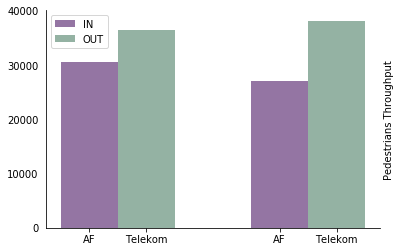

The buildings must be spawning pedestrians from the cellar 😱🧙
Or there might be different Entries to the building...


In [15]:
# as bar chart
bar_width = 0.3
print(count_walked_IN_tel)
bars1 = [count_walked_IN_af, count_walked_IN_tel]
bars2 = [count_walked_OUT_af, count_walked_OUT_tel]
# x position of bars
r1 = np.arange(len(bars1))
r2 = [x + bar_width for x in r1]
# create bars1
plt.bar(r1, bars1, width=bar_width, color=(0.3,0.1,0.4,0.6), capsize=7, label='IN')
plt.bar(r2, bars2, width=bar_width, color=(0.3,0.5,0.4,0.6), capsize=7, label='OUT')

# general layout
plt.xticks([0, 0.3, 1, 1.3], ['AF', 'Telekom', 'AF', 'Telekom'])
plt.ylabel('Pedestrians Throughput')
plt.gca().yaxis.set_label_position("right")
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)
# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Show graphic
plt.show()
print('The buildings must be spawning pedestrians from the cellar 😱🧙')
print('Or there might be different Entries to the building...')

In [42]:
# times = pd.to_datetime(df_pedestrians_IN_tel.Timestamp)
# pd.DatetimeIndex(times).hour

times = pd.DatetimeIndex(df_pedestrians_IN_af.Timestamp)
grouped = df_pedestrians_IN_af.groupby([times.hour])
grouped_direction_count = grouped['Direction'].count()
grouped_direction_count

Timestamp
0      261
1      226
2      213
3      133
4       74
5      130
6      227
7      771
8      897
9     1241
10    1172
11    1561
12    1224
13    1396
14    1026
15     988
16     499
17     412
18     310
19     307
20     182
21     146
22     236
23     208
Name: Direction, dtype: int64

In [50]:
sns.barplot(x=grouped_direction_count.index, y=grouped_direction_count)

AttributeError: 'Series' object has no attribute 'Direction'